In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder

%reload_kedro
model_description = catalog.load("yolov5_l_description")
trained_model = catalog.load("trained_model")
#encoder = YoloEncoder(model_description=model_description)
#trained_model = RepresentationModel(encoder=encoder)
trained_model = trained_model.eval()

2023-03-07 14:27:59,129 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):

2023-03-07 14:27:59,129 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.1.0"):

2023-03-07 14:27:59,248 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-07 14:27:59,249 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/pyth

2023-03-07 14:27:59.496 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [2]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / "flower01" / "images"

In [3]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch

image_reps = []

image_list = sorted(list(image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    image_reps.append(trained_model(image_ex)[0].detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 458/458 [01:06<00:00,  6.85it/s]


In [4]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / "flower01" / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.635938,0.238889,0.020833,0.037037,000001.txt
1,0,0.379427,0.065278,0.015104,0.034259,000001.txt
2,0,0.634375,0.245370,0.020833,0.037037,000002.txt
3,0,0.379948,0.068981,0.015104,0.034259,000002.txt
4,0,0.379948,0.069907,0.015104,0.034259,000003.txt
...,...,...,...,...,...,...
1987,0,0.495833,0.971759,0.030208,0.052778,000383.txt
1988,0,0.496875,0.976852,0.030208,0.046296,000384.txt
1989,0,0.497656,0.980093,0.028646,0.037963,000385.txt
1990,0,0.497135,0.986111,0.028646,0.027778,000386.txt


In [5]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [6]:
test_image_dir = dataset_path / "flower02" / "images"

test_image_reps = []

image_list = sorted(list(test_image_dir.iterdir()))
for image_path in tqdm(image_list):
    image = read_image(image_path.as_posix())
    image.requires_grad = False
    image = resize(image, (512, 512))
    image = image.to(torch.float) / 255
    image_ex = image[None, :, :, :]
    
    test_image_reps.append(trained_model(image_ex)[0].detach().numpy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:48<00:00,  6.88it/s]


In [7]:
test_labels_dir = dataset_path / "flower02" / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.407813,0.032870,0.014583,0.023148,000001.txt
1,0,0.408854,0.042130,0.014583,0.023148,000002.txt
2,0,0.408854,0.042130,0.014583,0.023148,000003.txt
3,0,0.408854,0.042130,0.014583,0.023148,000004.txt
4,0,0.408854,0.042130,0.014583,0.023148,000005.txt
...,...,...,...,...,...,...
1583,0,0.441406,0.814352,0.020313,0.036111,000287.txt
1584,0,0.437240,0.838426,0.020313,0.036111,000288.txt
1585,0,0.433073,0.858796,0.020313,0.036111,000289.txt
1586,0,0.434635,0.871759,0.011979,0.028704,000290.txt


In [8]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [9]:
# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = np.arange(len(image_reps))
test_indices = np.arange(len(image_reps), len(all_image_reps))

In [10]:
from sklearn.linear_model import RidgeCV

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg = RidgeCV(alphas=alphas, cv=((train_indices, test_indices),)).fit(all_image_reps_arr, all_flower_counts)

2023-03-07 14:30:21,029 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.96353e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T



In [11]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([    0.58056,      0.5641,     0.74656,     0.45662,     0.90921,      1.4635,       1.875,      1.3719,      1.1617,      1.2825,      1.2309,      1.0852,     0.89589,     0.48078,      0.9278,      1.0094,      0.6431,      1.7351,      2.3227,      1.8994,       1.516,      2.2096,      2.3904,      2.1751,
            2.9011,      2.5875,      2.5877,      3.3114,      2.6957,      2.3799,      2.6058,       2.151,      2.1533,      2.9728,      2.8035,      3.1658,      4.1238,      3.6793,      4.2177,      3.9664,      3.4252,       3.867,       3.952,      3.4174,      4.0295,      4.6991,      4.8069,      4.5663,
            4.3814,      4.3656,      3.8539,      4.4869,      4.4771,       4.722,      4.6282,      4.5298,      4.8702,      5.1029,      5.3018,      4.9713,      4.9985,       5.254,      5.8276,      5.7468,      6.1716,      6.2836,      6.3144,      6.6752,      6.5445,      6.4605,      6.6124,      5.8838,
            6.8427,      6.5554,       7.039,      7.1157,      7.3677,      7.2441,      7.1763,      6.6101,      6.9875,      6.9305,      7.1935,      7.1349,      8.0322,      7.1695,      7.1214,      8.0418,      8.1084,      8.1337,       8.247,      7.9158,      8.6127,      8.2848,      8.1871,       8.246,
            7.8146,      7.5039,      7.6217,      6.8245,      7.1588,      7.6763,      7.0386,      7.5636,      7.0264,      7.6475,      7.8087,      7.7804,      7.3065,      6.6991,      6.1963,      6.6096,      6.5227,       5.952,      6.3454,      6.7344,      6.7053,      6.7534,      5.6646,       5.391,
            5.6702,      6.6986,      6.1813,      6.5018,      6.0182,      5.5791,      5.3365,       5.674,      5.7713,      5.7023,      6.1199,      6.8782,      6.6639,      6.2583,      6.8232,      6.6421,      6.8446,      6.9824,      6.6835,      7.0834,      7.2636,       6.864,      7.1817,      6.2765,
            6.3875,      6.3269,      5.8799,      6.8362,      6.8844,       7.204,      7.0037,      6.5086,      6.4049,      6.3917,      6.3357,      5.8045,      6.6122,      6.3629,      6.2522,      6.1394,      6.3513,      6.4717,       5.679,      5.5545,      4.6273,      5.1416,      4.9658,      5.3671,
            5.7257,      6.1678,      5.9082,      5.6785,      5.4472,      5.2675,      6.4048,      6.4726,      5.9957,      6.2908,      5.8505,      5.9547,      6.5734,      6.2048,       6.603,      6.6179,      6.6719,      7.5903,      7.3055,       6.984,      6.8497,      7.3088,      7.6523,      7.7065,
            8.1973,      7.8822,      7.0423,      7.4916,       7.469,       6.385,      7.7975,      8.7105,      8.4703,      8.9802,      8.6418,      7.4842,        7.06,      8.2655,      7.4228,       6.671,      6.9394,      7.1792,      8.0458,      8.0314,      6.6147,      8.3647,      7.4457,      7.6361,
            7.2302,      7.8073,      6.4504,       7.479,      7.8038,      6.6727,      6.7181,      6.5102,      7.3043,      7.2537,      6.2445,      6.3683,      6.5595,      6.2744,      6.1319,      5.5262,      5.0083,      4.9966,      5.0118,      5.6837,      4.4976,       5.673,      4.4061,      5.4551,
            4.3637,      5.6829,      5.8745,      5.2035,      5.1274,      5.2987,      5.9818,      5.5764,      5.5224,      5.1852,      4.7063,      5.0463,      5.5292,      5.4068,      5.8217,      5.4078,      6.0024,      5.5765,      5.1885,      5.1062,      4.5464,      4.8567,       4.299,        4.84,
            4.9007,      4.1955,      3.8785,      4.1456,      3.8314,      3.7361,      3.6197,      3.8529,        3.42,      3.6455,      3.4924,      2.9509,      3.1374,      3.1606,      2.7436,      2.3833,      2.4522,      2.2514,      1.7627,      2.7758,      2.2938,      2.6875,      2.2215,      1.2218,
            1.2189,     0.45255,     0.72705,     0.14572,      1.1033,      1.2602,      1.4002,     0.29674,     0.59372,      0.2334,     0.22415,     0.69083,       0.5

In [12]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

0.6196759199952936

2023-03-07 14:30:30,646 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-07 14:30:30,647 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



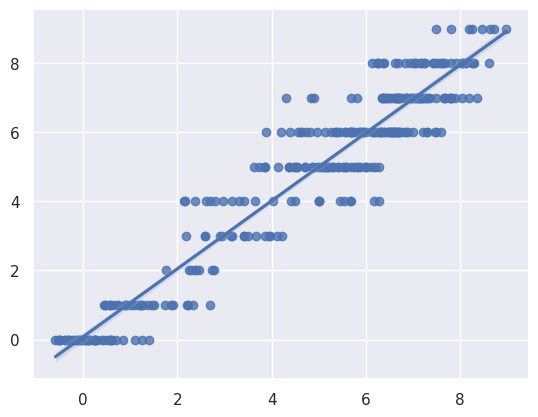

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_preds, y=test_flower_counts)
plt.show()

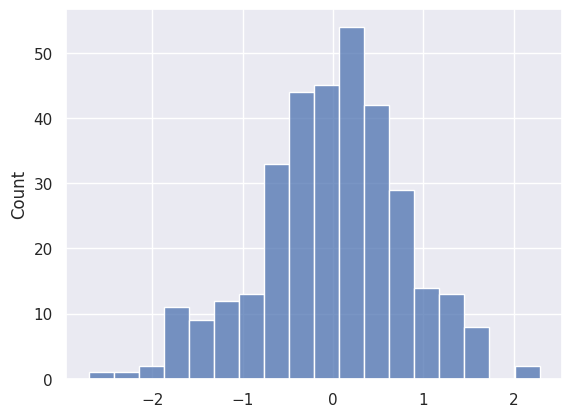

In [14]:
sns.histplot(x=errors)

In [15]:
import numpy as np

# Use the coefficient of variation of the differences between frames to provide a measure of "smoothness".
gt_diff = np.diff(test_flower_counts)
gt_smoothness = np.std(gt_diff) / np.abs(np.mean(gt_diff))
gt_smoothness

149.14087300267488

In [16]:
pred_diff = np.diff(test_preds)
pred_smoothness = np.std(pred_diff) / np.abs(np.mean(pred_diff))
pred_smoothness

287.2199

In [17]:
reps_diff = np.diff(test_image_reps_arr, axis=0)
reps_smoothness = np.std(reps_diff, axis=0) / np.abs(np.mean(reps_diff, axis=0))
np.mean(reps_smoothness)

351.88214